[[6.987040e-02 7.049980e-03]
 [1.923840e-01 4.059220e-02]
 [8.308090e-01 4.154045e-02]
 [2.950840e+00 1.475420e-01]
 [7.377370e+00 3.688685e-01]
 [9.502210e+00 4.751105e-01]
 [0.000000e+00 9.900000e+99]
 [1.516060e+01 7.580300e-01]
 [2.142950e+01 1.071475e+00]
 [3.460530e+01 1.730265e+00]
 [3.460900e+01 3.460900e+00]
 [5.131500e+01 5.131500e+00]
 [3.950320e+01 3.950320e+00]
 [2.687740e+01 2.687740e+00]
 [1.799710e+01 1.799710e+00]]


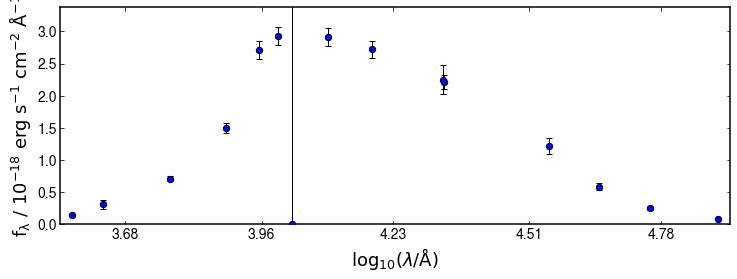

In [1]:
#setting up ie loading in the catalogue
import numpy as np 
import bagpipes as pipes
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib as mpl

def load_goodss(ID):
    """ Load UltraVISTA photometry from catalogue. """

    # load up the relevant columns from the catalogue.
    cat = np.loadtxt("hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
                     usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
                              11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
    # Find the correct row for the object we want.
    row = int(ID) - 1

    # Extract the object we want from the catalogue.
    fluxes = cat[row, :15]
    fluxerrs = cat[row, 15:]

    # Turn these into a 2D array.
    photometry = np.c_[fluxes, fluxerrs]

    # blow up the errors associated with any missing fluxes.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**99.]
            
    # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
    for i in range(len(photometry)):
        if i < 10:
            max_snr = 20.
            
        else:
            max_snr = 10.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr

    return photometry

print(load_goodss("17433"))

goodss_filt_list = np.loadtxt("filters1/goodss_filt_list.txt", dtype="str")

galaxy = pipes.galaxy("17433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list)
fig = galaxy.plot()

In [2]:
#fit instructions dictionary
exp = {}                                  # Tau-model star-formation history component
exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.

exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

nebular = {}                      # Nebular emission component
nebular["logU"] = -3.             # log_10(ionization parameter)

fit_instructions = {}                     # The fit instructions dictionary
fit_instructions["redshift"] = (0., 10.)  # Vary observed redshift from 0 to 10
fit_instructions["exponential"] = exp   
fit_instructions["dust"] = dust
fit_instructions["nebular"] = nebular

In [3]:
#performing the fit
fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)

Generating 500 samples from posterior. Total samples: 1955

Results loaded from pipes/posterior/./17433.h5

Fitting not performed as results have already been loaded from pipes/posterior/./17433.h5. To start over delete this file or change run.



In [4]:
fig = fit.plot_spectrum_posterior(save=True, show=True) # Shows the input and fitted spectrum/photometry
fig = fit.plot_sfh_posterior(save=True, show=True) # Shows the fitted star-formation history
fig = fit.plot_corner(save=True, show=True) #corner plot: # Shows 1d and 2d posterior probability distributions

In [5]:
print(np.median(fit.posterior.samples["stellar_mass"])) #posterior median living stellar mass
print(np.percentile(fit.posterior.samples["mass_weighted_age"], (16, 84))) #confidence interval on the mass-weighted age



10.95407050255995
[2.13067666 3.23412346]


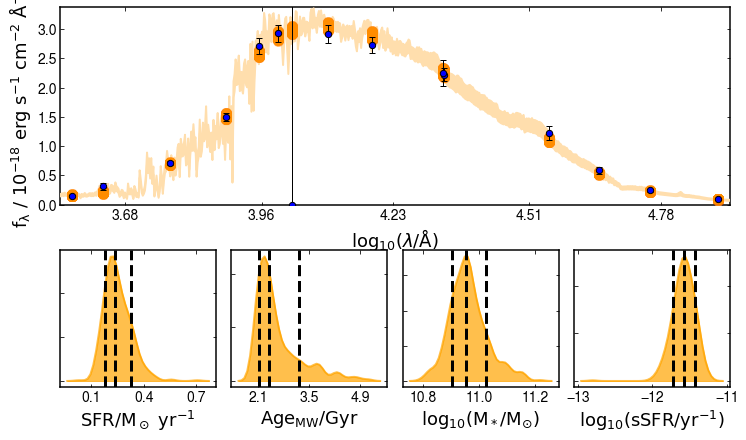

In [6]:
plt.close()
fig = plt.figure(figsize=(12, 7))
gs = mpl.gridspec.GridSpec(7, 4, hspace=3., wspace=0.1)

ax1 = plt.subplot(gs[:4, :])

pipes.plotting.add_observed_photometry(fit.galaxy, ax1, zorder=10)
pipes.plotting.add_photometry_posterior(fit, ax1)

labels = ["sfr", "mass_weighted_age", "stellar_mass", "ssfr"]

post_quantities = dict(zip(labels, [fit.posterior.samples[l] for l in labels]))

axes = []
for i in range(4):
    axes.append(plt.subplot(gs[4:, i]))
    pipes.plotting.hist1d(post_quantities[labels[i]], axes[-1], smooth=True, label=labels[i])

plt.show()